# Occurrence of new collaborations

In this notebook, we will analyze the occurrence of new collaborations over the years. We will look at the total number of articles published, the number of articles with new author collaborations, and the number of articles with new institution collaborations. We will also analyze the average collaboration novelty index over the years.

## Brief overview
Collaboration novelty index unexpectedly peaks in 2022. We checked whether this might be due to COVID articles, but that was not the case, so we excluded top and bottom 5% articles and re-drew the plot. The trend of collaboration novelty index is increasing over the years. Approximately half of the articles are new institution collaborations and the majority of articles are new author collaborations, meaning that we will have to better define what constitutes a new collaboration and what events are relevant to our research. 

The overall trend of new institution and author collaborations is increasing over time similarly as the number of total articles published.

### Imports & Global Variables

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
from box import Box
import matplotlib.pyplot as plt
import seaborn as sns
from util.postgres import create_sqlalchemy_connection, query

In [7]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yaml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)

# Initialize Postgres
pg_conn = create_sqlalchemy_connection(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)

# Set numpy random seed
np.random.seed(config.RANDOM_SEED)
# Set the Seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

### Collaboration Novelty Index Trend

We will query data from the `FCT_COLLABORATION_NOVELTY` table to analyze the average collaboration novelty index over the years.

In [9]:
sql_query = f"""
SELECT EXTRACT(YEAR FROM article_publication_dt) AS year,
       collaboration_novelty_index               AS collaboration_novelty_index_avg 
FROM fct_article
WHERE NOT is_single_author_collaboration
AND EXTRACT(YEAR FROM article_publication_dt) >=2010
"""

df = query(conn=pg_conn, query_str=sql_query)
df.head(5)

,year,collaboration_novelty_index_avg
0,2017.0,52.502797
1,2021.0,1.000036
2,2010.0,0.666787
3,2020.0,1.144428
4,2017.0,1.000203


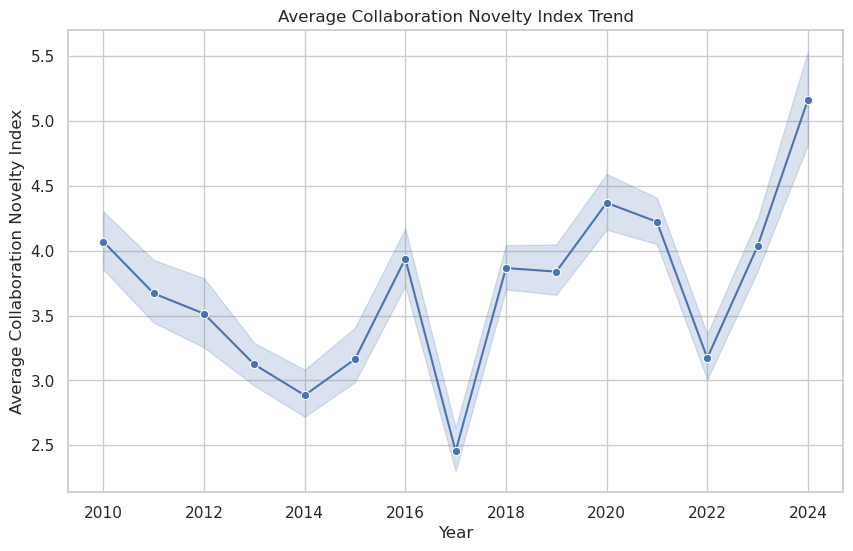

In [10]:

# Plot the average collaboration novelty index trend
sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='collaboration_novelty_index_avg', marker='o')
plt.title('Average Collaboration Novelty Index Trend')
plt.xlabel('Year')
plt.ylabel('Average Collaboration Novelty Index')
plt.show()


**Check if the increase in collaboration novelty index is due to COVID articles**

In [21]:
# Get maximum 100 values by collaboration novelty index (from 2022) including article name
sql_query = f"""
SELECT a.article_title,
       f.collaboration_novelty_index
FROM fct_article f
         INNER JOIN dim_article A USING (article_id)
WHERE EXTRACT(YEAR FROM f.article_publication_dt) = 2022
AND NOT f.is_single_author_collaboration
ORDER BY f.collaboration_novelty_index DESC
LIMIT 100
"""

df = query(conn=pg_conn, query_str=sql_query)

In [22]:
# Count the number of articles with 'SARS', 'CoV', 'COVID' or 'epidemic' in the title
df['article_title'] = df['article_title'].str.lower()

# Print count
covid_article_count = df[df['article_title'].str.contains('sars|cov|covid|epidemic')].shape[0]
print(f"COVID Articles: {covid_article_count:.0f}")
# Print average collaboration novelty index
cni_mean = df['collaboration_novelty_index'].mean()
print(f"Average Collaboration Novelty Index: {cni_mean:.2f}")
# Print average collaboration novelty index for COVID articles
cni_covid_mean = df[df['article_title'].str.contains('sars|cov|covid|epidemic')]['collaboration_novelty_index'].mean()
print(f"Average Collaboration Novelty Index for COVID Articles: {cni_covid_mean:.2f}")
# Print average collaboration novelty index for bottom 95% articles
cni_q_95 = df['collaboration_novelty_index'].quantile(0.95)
print(f"Average Collaboration Novelty Index for Bottom 95% Articles: {cni_q_95:.2f}")
df.head(10)

COVID Articles: 12
Average Collaboration Novelty Index: 157.36
Average Collaboration Novelty Index for COVID Articles: 166.94
Average Collaboration Novelty Index for Bottom 95% Articles: 303.53


,article_title,collaboration_novelty_index
0,ecological network complexity scales with area,812.000000
1,"single-course bleomycin, etoposide, and cispla...",666.000000
2,environmental dna metabarcoding for benthic mo...,595.000000
3,severe blistering eruptions induced by immune ...,450.039883
4,disgust sensitivity relates to attitudes towar...,370.580456
5,learning from natural sediments to tackle micr...,300.000000
6,the einstein effect provides global evidence f...,300.000000
7,vca in the era of the covid-19 pandemic,300.000000
8,phylogenomic analyses of the genus drosophila ...,300.000000
9,growing stock monitoring by european national ...,297.333333


In [27]:
## Exclude bottom and top 5% articles and redraw the plot

sql_query = f"""
SELECT EXTRACT(YEAR FROM article_publication_dt) AS year,
       collaboration_novelty_index
FROM fct_article
WHERE NOT is_single_author_collaboration
AND EXTRACT(YEAR FROM article_publication_dt) >=2010
"""

df = query(conn=pg_conn, query_str=sql_query)

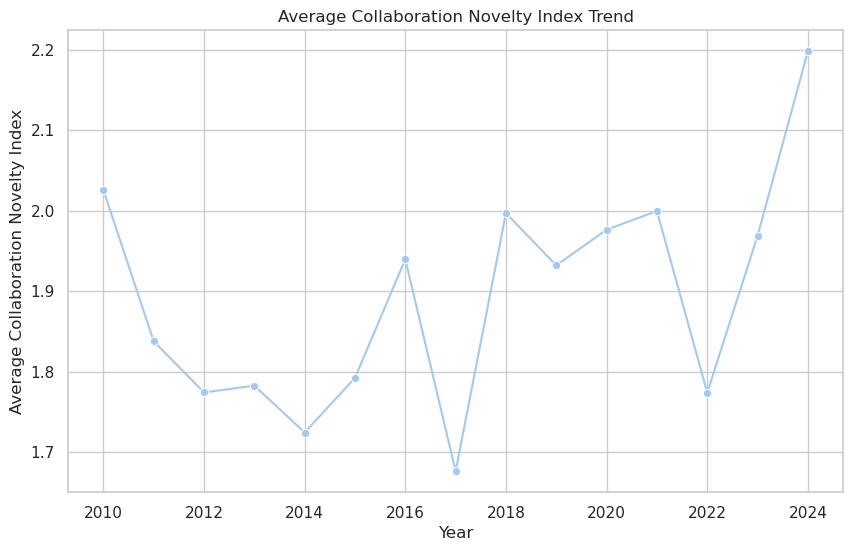

In [28]:
df = df[(df['collaboration_novelty_index'] > df['collaboration_novelty_index'].quantile(0.05)) & (
        df['collaboration_novelty_index'] < df['collaboration_novelty_index'].quantile(0.95))]

# Calculate the average collaboration novelty index by year
df = df.groupby('year').agg({'collaboration_novelty_index': 'mean'}).reset_index()

# Plot the average collaboration novelty index trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='collaboration_novelty_index', marker='o')
plt.title('Average Collaboration Novelty Index Trend')
plt.xlabel('Year')
plt.ylabel('Average Collaboration Novelty Index')
plt.show()


### Occurrence of New Collaborations Trend

We will query data from the `FCT_COLLABORATION` table to analyze the occurrence of new collaborations over the years. We will look at the total number of articles published, the number of articles with new author collaborations, and the number of articles with new institution collaborations.

In [29]:
sql_query = f"""
SELECT EXTRACT(YEAR FROM article_publication_dt)                                       AS year,
       COUNT(DISTINCT article_id)                                                      AS article_count,
       COUNT(DISTINCT CASE
                          WHEN has_new_author_collaboration AND NOT has_new_institution_collaboration
                              THEN article_id END)                                     AS new_author_collaboration_count,
       COUNT(DISTINCT CASE
                          WHEN has_new_institution_collaboration
                              THEN article_id END)                                     AS new_institution_collaboration_count,
       COUNT(DISTINCT CASE
                          WHEN NOT has_new_author_collaboration AND NOT has_new_institution_collaboration
                              THEN article_id END)                                     AS existing_collaboration_count
FROM fct_collaboration
WHERE EXTRACT(YEAR FROM article_publication_dt) >= 2010
GROUP BY 1
ORDER BY 1 ASC
"""

trend_df = query(conn=pg_conn, query_str=sql_query)
trend_df.head(50)

,year,article_count,new_author_collaboration_count,new_institution_collaboration_count,existing_collaboration_count
0,2010.0,16596,5307,7557,4107
1,2011.0,18355,5392,8549,4986
2,2012.0,20336,5777,9522,5732
3,2013.0,22225,6147,10659,6214
4,2014.0,23992,3470,12036,8962
5,2015.0,23617,3725,12151,8177
6,2016.0,25265,6962,12944,6195
7,2017.0,26348,1971,14069,10540
8,2018.0,26989,6105,14732,6840
9,2019.0,28728,6316,15575,7659


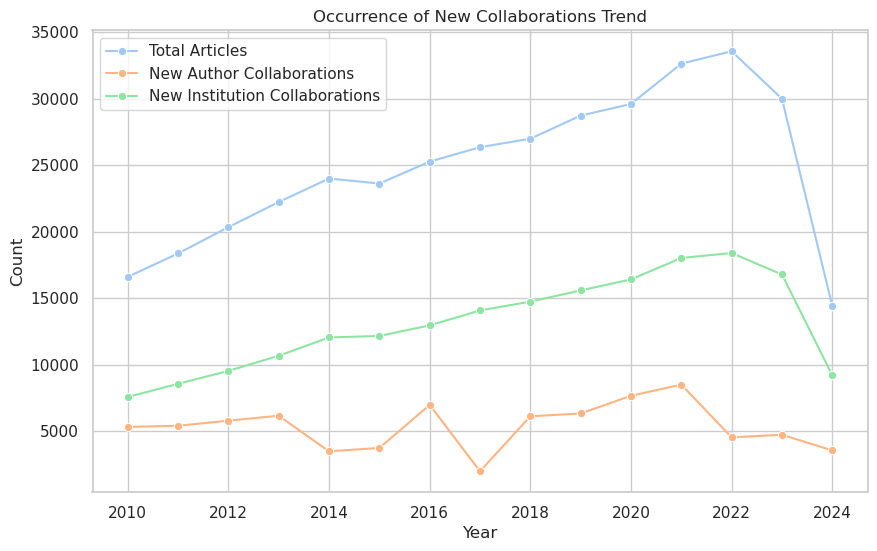

In [30]:
# Plot the occurrence of new collaborations trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=trend_df, x='year', y='article_count', marker='o', label='Total Articles')
sns.lineplot(data=trend_df, x='year', y='new_author_collaboration_count', marker='o', label='New Author Collaborations')
sns.lineplot(data=trend_df, x='year', y='new_institution_collaboration_count', marker='o',
             label='New Institution Collaborations')
plt.title('Occurrence of New Collaborations Trend')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

## Collaboration Novelty Thesis Plot

In [32]:
sql_query = f"""
WITH articles AS (SELECT DISTINCT article_id
                  FROM fct_collaboration)
SELECT f.article_id,
       f.collaboration_novelty_index
FROM fct_article f
         INNER JOIN articles USING (article_id)
WHERE EXTRACT(YEAR FROM f.article_publication_dt) >= 2010
"""

distribution_df = query(conn=pg_conn, query_str=sql_query)
distribution_df.head(5)

,article_id,collaboration_novelty_index
0,85132338055,0.000000
1,85018362484,52.502797
2,2-s2.0-85115998003,1.000036
3,84882441708,0.666787
4,85085644187,1.144428


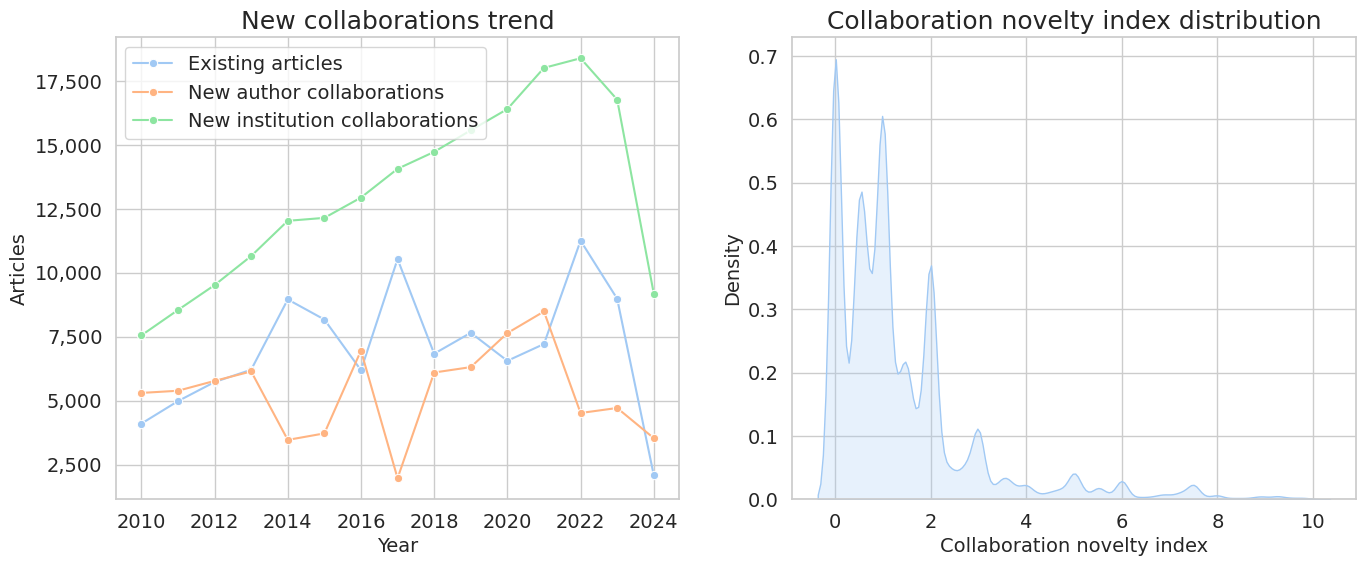

In [33]:
from matplotlib import ticker

plt.rcParams.update({
    'font.size': 14,          # Global font size
    'axes.titlesize': 18,     # Title font size
    'axes.labelsize': 14,     # X and Y label font size
    'xtick.labelsize': 14,    # X tick label font size
    'ytick.labelsize': 14,    # Y tick label font size
    'legend.fontsize': 14,    # Legend font size
    'figure.titlesize': 18    # Figure title font size
})


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# Cutoff the outliers top 5 percentiles
distribution_df_cut = distribution_df[
    (distribution_df['collaboration_novelty_index'] <
     distribution_df['collaboration_novelty_index'].quantile(
         0.95))]

# Define custom bins
custom_bins = np.linspace(distribution_df_cut['collaboration_novelty_index'].min(),
                          distribution_df_cut['collaboration_novelty_index'].max(), 30)

# Pre-calculate histogram values
counts, bin_edges = np.histogram(distribution_df_cut['collaboration_novelty_index'], bins=custom_bins)

# Plot the pre-calculated histogram values
sns.kdeplot(ax=ax2, data=distribution_df_cut['collaboration_novelty_index'], label='Density', fill=True)
ax2.set_xlabel('Collaboration novelty index')
ax2.set_title('Collaboration novelty index distribution')
# ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

sns.lineplot(data=trend_df, x='year', y='existing_collaboration_count', marker='o', label='Existing articles', ax=ax1)
sns.lineplot(data=trend_df, x='year', y='new_author_collaboration_count', marker='o', label='New author collaborations', ax=ax1)
sns.lineplot(data=trend_df, x='year', y='new_institution_collaboration_count', marker='o', 
             label='New institution collaborations', ax=ax1)
ax1.set_title('New collaborations trend')
ax1.set_xlabel('Year')
ax1.set_ylabel('Articles')
ax1.legend(loc='upper left')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.savefig('../assets/report_figures/collaboration_novelty.png')
plt.show()